In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from IPython import display

In [2]:
# Hyper Parameters for DQN
N_ACTIONS = 1001    # 1000 values
N_STATES = 2        # [set value, process output value]

In [ ]:
if torch.cuda.is_available():
    _cuda_ = True
else:
    _cuda_ = False

In [ ]:
_cuda_

In [3]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        if _cuda_:
            self.fc1 = nn.Linear(N_STATES, 50).cuda()
            self.fc1.weight.data.normal_(0, 0.1)   # initialization
            self.out = nn.Linear(50, N_ACTIONS).cuda()
            self.out.weight.data.normal_(0, 0.1)   # initialization
        else:
            self.fc1 = nn.Linear(N_STATES, 50)
            self.fc1.weight.data.normal_(0, 0.1)   # initialization
            self.out = nn.Linear(50, N_ACTIONS)
            self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [4]:
class DQN(object):
    def __init__(self):
        self.eval_net = Net()

    def choose_action(self, x):
        if _cuda_:
            x = torch.unsqueeze(torch.FloatTensor(x), 0).cuda()
        else:
            x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].cpu().data.numpy()
        action = action[0]  # return the argmax index
        return action
    
    def take_action(self, a, factor): # a = index of output node, 0~10
        value = a*0.01
        return value
    
    def reward(self, s):  # s = [set_value, process_output, d(process_output)/dt]
        error = abs(s[1] -s[0]) # process_output - set_value
        r = -(error**2)*1000
        return r

In [5]:
dqn = DQN()

In [6]:
# Load trained weight
dqn.eval_net.load_state_dict(torch.load('2018_09_28_dqn.pkl'))

In [8]:
a = dqn.choose_action([1.5, 2.0])
print(a)

7


# Define the control process  

In [9]:
# Hyper Parameters for process
ns = 2000  # number of steps
t = np.linspace(0,ns/10,ns+1) # time points, if 10 control steps/per second, then 1 min. has 600 steps 
delta_t = t[1]-t[0]

KP=1.0    # process gain
TAUP =20.0 #process time constant

sv = np.zeros(ns+1)  # set point
p_out = np.zeros(ns+1)  # record process output
p_out_unit_step = np.zeros(ns+1)  # process output from unit step
action = np.zeros(ns+1) #RL Controller output
reward = np.zeros(ns+1)

In [10]:
# process model
def process(y,t,u,Kp,taup):
    dydt = -y/taup + Kp/taup * u
    return dydt

In [11]:
n_a = 1.0
noise= (n_a)+n_a*np.sin(np.linspace(0., (10)*np.pi, ns+1))

# Control the process use the trained DQN

In [ ]:
# Duild different set value 
def Compose_sv():
    start_index = 0
    end_index = 0
    max_range = ns/5 
    min_range = ns/20
    max_sv = 8
    min_sv = 0.1
    finish = False 
    while not finish:
        end_index = start_index + random.randint(min_range, max_range)
        value = random.uniform(min_sv, max_sv)
        if end_index > ns:
            end_index = ns
            finish = True
        sv[start_index:end_index] = value
        print("sv[", start_index, ':', end_index, ']=', value)
        start_index = end_index

In [12]:
Compose_sv()

In [ ]:
plt.figure(figsize=(18,4)) 
plt.plot(sv, 'r', lw =2)
plt.xlabel('i')
plt.ylabel('s[i]')
plt.xticks(np.arange(0, 100000, step=5000))
plt.show()

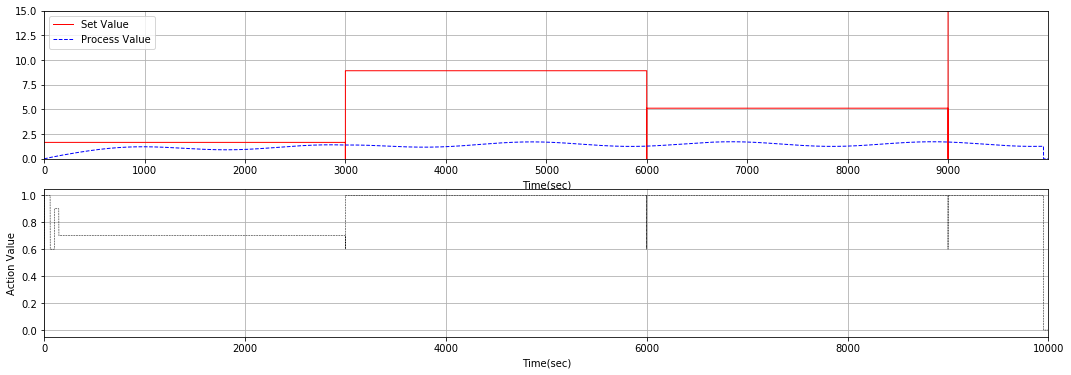

Episode:  1 , Control step = 99500 , Time =  9950.0 (sec)
Ep_r =  -500135.14


In [13]:
ep_rLst = []
for i_episode in range(1):
    ep_r = 0   
    Compose_sv()
    s = [sv[0], 0.0, 0.0]  # initial state = [set_value, process_output=0, d(process_output)/dt=0]
    p_out[:]=0.0
    action[:]=0.0 #clear data
    for i in range(0, ns): # run control steps
        a = dqn.choose_action(s)         # a = index of the 11 output nodes, 0~10
        action[i] = dqn.take_action(a, 0.1)   # action = 0, 1*factor, 2*factor, ..., 10*factor
        if action[i] > ACTION_HI:
            action[i] = ACTION_HI
        elif action[i] < ACTION_LOW:
            action[i] = ACTION_LOW
        y = odeint(process,p_out[i],[0,delta_t],args=(action[i]+noise[i],KP,TAUP))
        p_out[i+1] = y[-1][0]
        dp_out[i+1] = (p_out[i+1]-p_out[i])/delta_t
        s_ = [sv[i+1], p_out[i+1], dp_out[i+1]]   # state = [set_value, process_output, d(process_output)/dt]
        r = dqn.reward(s_)      
        ep_r += r
        s = s_
        if(i%500 == 0):
            # draw process control performance
            display.clear_output(wait=True)
            plt.figure(figsize=(18,6))
            plt.subplot(2, 1, 1) # 1 row * 2columns
            plt.plot(t, sv, 'r-', lw =1, label='Set Value')
            plt.plot(t, p_out, 'b--', lw =1, label='Process Value')
            plt.legend(loc = 'best')
            plt.xlabel('Time(sec)')
            plt.xlim([0, 10000])
            plt.ylim([0, 15])
            plt.xticks(np.arange(0, 10000, step=1000))
            plt.grid()

            plt.subplot(2, 1, 2) 
            plt.plot(t, action, 'k--', lw =0.5)
            plt.xlabel('Time(sec)')
            plt.ylabel('Action Value')
            plt.xlim([0, 10000])
            plt.grid(True)
            plt.pause(0.1)
            print('Episode: ', i_episode+1, ', Control step =', i, ', Time = ', i/10, '(sec)')
    # finish one episode 
    ep_r = round(ep_r, 2)
    print('Ep_r = ', ep_r)
    ep_rLst.append(ep_r)